## Data Handling

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import pickle
import matplotlib
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
np.random.seed(4444)

In [6]:
df = pd.read_csv('../../../../../../jaeyeun/01_nh_poc/16_re_label/split_70_15_15_re_3_prep_v10.csv')

df.head()

,file_name,raw_text,dataset_n,label_1,label_2,label_3,label_4,train_val_test,prep_v10_text
0,D1512065.txt,보 도 자 료\nhttp://www.motie.go.kr 2015년 12월28일(월...,0,0,0,0,0,0,가능N 국가N 기술N 표준원N 기술N 규제N 조정N 오광N 과장N 연구사N 기업N ...
1,R2002420.txt,보 도 자 료 작성과 공공데이터정책과\n2020년 2월 13일(목) 조간 (2. 1...,0,0,0,0,0,0,공공N 데이터N 정책N 이후N 남호N 공공N 데이터N 청년N 인턴N 참가N 청년N ...
2,R2002370.txt,2020년 2월 11일(화) 석간부터 보도하여 주시기 바랍니다. * 통신․방송․인터...,0,0,0,0,0,0,가능N 벤처N 투자N 과장N 벤처N 혁신N 정책N 과장N 벤처N 생태N 민간N 중심...
3,R2004373.txt,보도참고자료\nhttp://www.motie.go.kr 배포 즉시 보도하여 주시기 ...,0,0,0,0,0,0,즉시N 기정N 통부N 연구N 개발N 정책N 판식N 정보N 기술N 정책N 연구N 제도...
4,D1506066.txt,보 도 자 료\n보도일시 2015. 6. 12.(금) 조간(온라인 6. 11. 12...,0,0,0,0,0,0,온라인N 이후N 디지털N 정책N 과장N 지운N 스마트미디어N 엑스N 캠프N 신규N ...


* exp3 combination & label_4

In [7]:
X_train_df = df[df['train_val_test'] == 0]
X_val_df = df[df['train_val_test'] == 1]
X_test_df = df[df['train_val_test'] == 2]
y_train = df[df['train_val_test'] == 0]['label_4']
y_val = df[df['train_val_test'] == 1]['label_4']
y_test = df[df['train_val_test'] == 2]['label_4']

In [8]:
print(X_train_df.shape)
print(X_val_df.shape)
print(X_test_df.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(7741, 9)
(1663, 9)
(1669, 9)
(7741,)
(1663,)
(1669,)


In [9]:
n_features = 100000
tfidf_vectorizer = TfidfVectorizer(
    max_df=0.9, # 0.9 만큼의 문서 이상에서 나오면 거른다.
    min_df=5, # 5개 미만의 문서에서 나오면 거른다.
    sublinear_tf = True, # tf value를 완만하게 처리 (outlier 처리 효과)
    ngram_range = (1, 3),
    max_features=n_features)

* data is 'prep_v10_text'

In [10]:
X_train_tfidf = tfidf_vectorizer.fit(X_train_df['prep_v10_text'])
# X_test_tfidf = tfidf_vectorizer.fit_transform(prep_text_test)
# X_test_hash = hash_vectorizer.fit_transform(prep_text_test)

In [11]:
X_train = X_train_tfidf.transform(X_train_df['prep_v10_text'])
X_val = X_train_tfidf.transform(X_val_df['prep_v10_text'])
X_test = X_train_tfidf.transform(X_test_df['prep_v10_text'])

In [12]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(7741, 100000)
(1663, 100000)
(1669, 100000)


## Classify

* learn by LightGBM RandomSearch

In [25]:
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgbm

In [11]:
lgbm_clf = lgbm.LGBMClassifier()

lgbm_param_grid = {'learning_rate': [.01, .015, .025, .05, .1],
#                   'Gamma': [.05, .1, .3, .5, .7, .9, 1],
                  'max_depth': [3, 5, 7, 9, 12, 15, 17, 25],
                  'min_child_weight': [1, 3, 5, 7],
                   'device': ['gpu'],
                  'subsample': np.linspace(0.6, 1, 5)}

fit_params = {"early_stopping_rounds" : 20,
             "eval_metric" : "multi_error",
             "eval_set" : [(X_train, y_train), (X_val, y_val)]}

# Create a random search object
lgbm_random = RandomizedSearchCV(estimator = lgbm_clf,
                                param_distributions = lgbm_param_grid,
                                n_iter = 20, # n_iters in param combinations
                                scoring='accuracy',
                                n_jobs=64,
                                cv = 5,
                                refit=True,
                                return_train_score = True,
                                verbose=10)

# Fit to the training data
lgbm_random.fit(X_train, y_train, **fit_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done   6 out of 100 | elapsed: 16.8min remaining: 263.2min
[Parallel(n_jobs=64)]: Done  17 out of 100 | elapsed: 22.3min remaining: 109.1min
[Parallel(n_jobs=64)]: Done  28 out of 100 | elapsed: 24.9min remaining: 64.1min
[Parallel(n_jobs=64)]: Done  39 out of 100 | elapsed: 32.1min remaining: 50.1min
[Parallel(n_jobs=64)]: Done  50 out of 100 | elapsed: 39.5min remaining: 39.5min
[Parallel(n_jobs=64)]: Done  61 out of 100 | elapsed: 41.1min remaining: 26.3min
[Parallel(n_jobs=64)]: Done  72 out of 100 | elapsed: 43.2min remaining: 16.8min
[Parallel(n_jobs=64)]: Done  83 out of 100 | elapsed: 47.0min remaining:  9.6min
[Parallel(n_jobs=64)]: Done  94 out of 100 | elapsed: 49.3min remaining:  3.1min
[Parallel(n_jobs=64)]: Done 100 out of 100 | elapsed: 55.4min finished


[1]	training's multi_error: 0.354864	training's multi_logloss: 1.94718	valid_1's multi_error: 0.398677	valid_1's multi_logloss: 1.97064
Training until validation scores don't improve for 20 rounds
[2]	training's multi_error: 0.201395	training's multi_logloss: 1.73006	valid_1's multi_error: 0.255562	valid_1's multi_logloss: 1.76992
[3]	training's multi_error: 0.154631	training's multi_logloss: 1.56097	valid_1's multi_error: 0.217078	valid_1's multi_logloss: 1.61779
[4]	training's multi_error: 0.132283	training's multi_logloss: 1.42156	valid_1's multi_error: 0.19543	valid_1's multi_logloss: 1.49294
[5]	training's multi_error: 0.119623	training's multi_logloss: 1.30372	valid_1's multi_error: 0.190018	valid_1's multi_logloss: 1.38774
[6]	training's multi_error: 0.111484	training's multi_logloss: 1.2008	valid_1's multi_error: 0.185207	valid_1's multi_logloss: 1.29681
[7]	training's multi_error: 0.1058	training's multi_logloss: 1.11157	valid_1's multi_error: 0.184606	valid_1's multi_logloss:

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=20, n_jobs=64,
                   param_distributions={'device': ['gpu'],
                                        'learning_rate': [0.01, 0.015, 0.025,
                                                          0.05, 0.1],
                                        'max_depth': [3, 5, 7, 9, 12, 15, 17,
                                                      25],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   return_train_score=True, scoring='accuracy', verbose=10)

* Inference

In [73]:
pred_train = lgbm_random.best_estimator_.predict(X_train)
pred_val = lgbm_random.best_estimator_.predict(X_val)
pred_test = lgbm_random.best_estimator_.predict(X_test)

# Analysis

* metric

In [13]:
print(accuracy_score(y_train, pred_train))
print(accuracy_score(y_val, pred_val))
print(accuracy_score(y_test, pred_test))

0.9975455367523576
0.8737221888153939
0.871779508687837


In [18]:
with open('./LightGBM_model.txt', 'wb') as f:
    pickle.dump(lgbm_random, f)

In [3]:
with open('./LightGBM_model.txt', 'rb') as f:
    lgbm_random = pickle.load(f)

In [4]:
cv_result_df = pd.DataFrame(lgbm_random.cv_results_)

df_list = []
for i in range(20):
    df_list.append(pd.DataFrame([cv_result_df.loc[i, "params"]]))
    
param_table = pd.concat(df_list)

param_table['mean_test_score'] = cv_result_df['mean_test_score'].values

param_table.sort_values(by='mean_test_score', axis=0)

,subsample,min_child_weight,max_depth,learning_rate,device,mean_test_score
0,0.6,1,3,0.010,gpu,0.776899
0,0.8,5,3,0.015,gpu,0.790722
0,0.9,7,5,0.010,gpu,0.810358
0,0.8,5,9,0.010,gpu,0.823664
0,0.6,1,5,0.025,gpu,0.831674
0,0.8,3,5,0.025,gpu,0.833224
0,0.9,7,15,0.025,gpu,0.835550
0,1.0,5,15,0.015,gpu,0.836195
0,0.6,7,25,0.025,gpu,0.837228
0,0.8,7,15,0.025,gpu,0.837876


* Top-2 accuracy

In [13]:
np.argsort(lgbm_random.best_estimator_.predict_proba(X_test)[0])[-2:]

array([8, 0])

In [14]:
np.array(y_test)

array([0, 0, 0, ..., 8, 8, 8])

In [15]:
probs = lgbm_random.best_estimator_.predict_proba(X_test)

In [16]:
best_n = np.argsort(probs, axis=1)[:, -2:]
best_n

array([[8, 0],
       [8, 0],
       [3, 0],
       ...,
       [7, 1],
       [8, 1],
       [8, 1]])

In [17]:
np.mean(np.array([1 if np.array(y_test)[k] in best_n[k] else 0 for k in range(len(best_n))]))

0.9592570401437986

* importance

In [19]:
feature_array = np.array(X_train_tfidf.get_feature_names())
importances = lgbm_random.best_estimator_.feature_importances_

In [20]:
tfidf_sorting = np.argsort(importances)[::-1]

In [21]:
n = 20
top_n = feature_array[tfidf_sorting][:n]

In [22]:
for i in range(len(top_n)):
    top_n[i] = top_n[i].replace('n', '')

In [23]:
top_n

array(['가능', '금융', '안전', '정책', '보건복지부', '경제', '사업', '지원', '주요', '기업',
       '산업', '이번', '계획', '연락', '교육', '기술', '기준', '경우', '고용', '기관'],
      dtype='<U37')

In [24]:
lgbm.plot_importance(lgbm_random.best_estimator_, max_num_features=10)

NameError: name 'lgbm' is not defined

In [26]:
top_n_label = top_n

In [27]:
top_n_importances = np.array(sorted(importances)[-20:])
index = np.arange(len(top_n_label))

In [28]:
filter_index = [1,2,3,6,7,9,10,14,15,18]

In [29]:
mod_10_label = top_n_label[filter_index]
mod_10_imp = top_n_importances[filter_index]
index = np.arange(len(mod_10_label))

* font

In [31]:
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list[:10]

['/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumPen.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothicBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumGothicLight.ttf',
 '/usr/share/fonts/truetype/nanum/NanumMyeongjoBold.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
 '/usr/share/fonts/truetype/nanum/NanumBrush.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquareL.ttf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf']

In [32]:
fm.get_fontconfig_fonts()
# font_location = '/usr/share/fonts/truetype/nanum/NanumGothicOTF.ttf'
font_location = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)

In [37]:
plt.rcParams['font.family']

['NanumGothic']

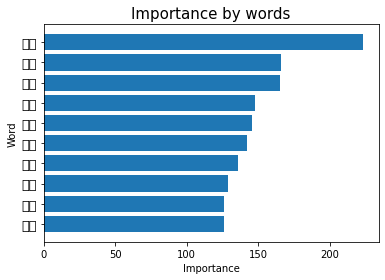

In [35]:
# plt.rc('font', family='Malgun Gothic')
plt.barh(index, mod_10_imp)
plt.title('Importance by words', fontsize=15)
plt.ylabel('Word', fontsize=10)
plt.xlabel('Importance', fontsize=10)
plt.yticks(index, mod_10_label, fontsize=13, rotation=0)
plt.rc('font', family=font_name)
plt.show()

* modify for confusion matrix and t-SNE

In [74]:
X_test_df['pred'] = pred_test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [88]:
pred_dic = {}
count = 0
proba = lgbm_random.best_estimator_.predict_proba(X_test)
x_leave = lgbm_random.best_estimator_.predict_proba(X_test, pred_leaf=True)
x_shap = lgbm_random.best_estimator_.predict_proba(X_test, pred_contrib=True)

for idx, row in X_test_df.iterrows():
    name = row['file_name']
    label = row['label_4']
    pred = row['pred']
    dataset_n = row['dataset_n']
    
    pred_dic[name] = {'label':label,
                      'pred':pred,
                      'dataset_n':dataset_n,
                      'softmax':proba[count],
                      'X_leaves':x_leave[count],
                      'X_SHAP_values':x_shap[count]}
    count += 1

In [89]:
with open('./lgbm_test_prediction.pickle', 'wb') as f:
    pickle.dump(pred_dic, f)

In [77]:
X_test_df

,file_name,raw_text,dataset_n,label_1,label_2,label_3,label_4,train_val_test,prep_v10_text,pred
911,R1803034.txt,문의 산업재산정책국 과 장 박호형...,0,0,0,0,0,2,산업N 재산N 정책N 산업N 재산N 정책N 균상N 즉시N 특허청N 발명N 진흥N 시...,0
912,R2002996.txt,2020년 2월 26일(수) 조간부터 보도하여 주시기 바랍니다. * 통신․방송․인터...,0,0,0,0,0,2,가능N 중소N 벤처N 기업N 기술N 개발N 과장N 중소기업N 기술N 정보N 흥원N ...,0
913,R2001686.txt,보도일시 2020. 1. 21.(화) 배포시점부터 보도해 주시기 바랍니다.\n배포일...,0,0,0,0,0,2,시점N 정통부N 데이터N 진흥N 식품N 과학기술정책N 과장N 과장N 연구관N 인공지...,0
914,R2005891.txt,보 도 자 료\nhttp://www.motie.go.kr 2020년 5월 22일(금...,0,0,0,0,0,2,가능N 인증N 산업N 진흥N 과장N 연구관N 기술N 제품N 제조업N 견인N 기술N ...,0
915,R1906707.txt,보 도 자 료\n2019년 6월 20일(목) 조간부터 보도하여 주시기 바랍니다. (...,0,0,0,0,0,2,가능N 산업N 통상N 자원N 산업N 정책N 산업N 통상N 자원N 산업N 정책N 과장...,0
...,...,...,...,...,...,...,...,...,...,...
11068,(117)한국조폐공사와 비밀유지협약서 검토.txt,변호사 기획역 (2020.5.22) 업 무 연 락 수 ...,1,8,8,8,8,2,기획N 카드N 회원N 사업N 공공사업N 참조N 계장N 준법N 감시N 법무N 조폐공사...,0
11069,(65)NH농협은행 수련원 이용수칙 개정(안) 검토 회신.txt,코오 로서 무든 86@시 0러 제꺼 받음 수 외으며 모른 @럭음은 모니티팅 6니다\...,2,8,8,8,8,2,모니N 농심N 가슴N 농민N 농심N 태을N 가슴N 농민N 농협N 은행N 농협N 은행...,1
11070,(49)사해행위 소송 실익 검토.txt,사해행위 소송 실익 검토 “농심(農心)을 가슴에 안고 농민(農民) 곁으로!” ...,1,8,1,1,8,2,사해행위N 소송N 실익N 검토N 농심N 농심N 가슴N 농민N 농민N 수신N 은행N ...,1
11071,(24)고성군지부(경남) 민원 건 관련 질의에 대한 회신.txt,고성군지부 민원 건 관련 질의에 대한 회신 “농심(農心)을 가슴에 안고 농민(農...,1,8,8,8,8,2,고성군N 지부N 민원N 질의N 회신N 농심N 농심N 가슴N 농민N 농민N 수신N 은...,1


In [39]:
a = lgbm_random.best_estimator_

In [54]:
a

LGBMClassifier(device='gpu', max_depth=9, min_child_weight=7)

In [58]:
x_leave = a.predict_proba(X_test, pred_leaf=True)
x_shap_ = a.predict_proba(X_test, pred_leaf=True, pred_contrib=True)
x_shap = a.predict_proba(X_test, pred_contrib=True)

In [60]:
print(x_leave.shape)
print(x_shap_.shape)
print(x_shap.shape)

(1669, 970)
(1669, 1000010)
(1669, 1000010)
